# Language Translation
In this project, you’re going to take a peek into the realm of neural network machine translation.  You’ll be training a sequence to sequence model on a dataset of English and French sentences that can translate new sentences from English to French.
## Code Tools and Links

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: azure;}
a {color: cadetblue; font-family: Roboto;}
h1, h2 {color: #48D1CC; font-family: Orbitron; text-shadow: 4px 4px 4px #ccc;}
h3, h4 {color: cadetblue; font-family: Roboto; text-shadow: 4px 4px 4px #ccc;}        
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: cadetblue;}      
div.output_stderr pre {background-color: azure;}  
div.output_stderr {background-color: slategrey;}     
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: cadetblue; background: azure; text-shadow: 4px 4px 4px #ccc;" \ 
type="submit" value="Click to display or hide code cells">
</form>

In [44]:
hide_code = ''
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import pickle
import copy
import numpy as np

import tensorflow as tf
from tensorflow.python.layers.core import Dense

from distutils.version import LooseVersion
import warnings
import time

import itertools
import collections
from matplotlib import pyplot

In [3]:
hide_code = ''
# https://github.com/udacity/deep-learning/blob/master/language-translation/helper.py (old version)
CODES = {'<PAD>': 0, '<EOS>': 1, '<UNK>': 2, '<GO>': 3 }

def load_data(path):
    """Load Dataset from File"""
    input_file = os.path.join(path)
    with open(input_file, 'r', encoding='utf-8') as f:
        data = f.read()
    return data

def preprocess_and_save_data(source_path, target_path, text_to_ids):
    """Preprocess Text Data.  Save to to file."""
    # Preprocess
    source_text = load_data(source_path)
    target_text = load_data(target_path)
    
    source_text = source_text.lower()
    target_text = target_text.lower()

    source_vocab_to_int, source_int_to_vocab = create_lookup_tables(source_text)
    target_vocab_to_int, target_int_to_vocab = create_lookup_tables(target_text)

    source_text, target_text = text_to_ids(source_text, target_text, 
                                           source_vocab_to_int, target_vocab_to_int)

    # Save Data
    pickle.dump((
        (source_text, target_text),
        (source_vocab_to_int, target_vocab_to_int),
        (source_int_to_vocab, target_int_to_vocab)), open('preprocess.p', 'wb'))
    
def load_preprocess():
    """Load the Preprocessed Training data and return them in batches of <batch_size> or less"""
    return pickle.load(open('preprocess.p', mode='rb'))

def create_lookup_tables(text):
    """ Create lookup tables for vocabulary"""
    vocab = set(text.split())
    vocab_to_int = copy.copy(CODES)

    for v_i, v in enumerate(vocab, len(CODES)):
        vocab_to_int[v] = v_i

    int_to_vocab = {v_i: v for v, v_i in vocab_to_int.items()}
    return vocab_to_int, int_to_vocab

def save_params(params):
    """Save parameters to file"""
    pickle.dump(params, open('params.p', 'wb'))

def load_params():
    """Load parameters from file"""
    return pickle.load(open('params.p', mode='rb'))

def batch_data(source, target, batch_size):
    """Batch source and target together"""
    for batch_i in range(0, len(source)//batch_size):
        start_i = batch_i * batch_size
        source_batch = source[start_i:start_i + batch_size]
        target_batch = target[start_i:start_i + batch_size]
        yield np.array(pad_sentence_batch(source_batch)), np.array(pad_sentence_batch(target_batch))

def pad_sentence_batch(sentence_batch):
    """Pad sentence with <PAD> id"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [CODES['<PAD>']] * (max_sentence - len(sentence))
            for sentence in sentence_batch]        

In [18]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/language-translation/problem_unittests.py (old version)
def _print_success_message():
    print('Tests Passed')

def test_text_to_ids(text_to_ids):
    test_source_text = \
    'new jersey is sometimes quiet during autumn , and it is snowy in april .\nthe united states \
    is usually chilly during july , and it is usually freezing in november .\ncalifornia is usually \
    quiet during march , and it is usually hot in june .\nthe united states is sometimes mild \
    during june , and it is cold in september .'
    test_target_text = \
    'new jersey est parfois calme pendant l\' automne , et il est neigeux en \
    avril .\nles états-unis est généralement froid en juillet , et il gèle habituellement \
    en novembre .\ncalifornia est généralement calme en mars , et il est généralement chaud \
    en juin .\nles états-unis est parfois légère en juin , et il fait froid en septembre .'

    test_source_text = test_source_text.lower()
    test_target_text = test_target_text.lower()

    source_vocab_to_int, source_int_to_vocab = create_lookup_tables(test_source_text)
    target_vocab_to_int, target_int_to_vocab = create_lookup_tables(test_target_text)

    test_source_id_seq, test_target_id_seq = text_to_ids(test_source_text, test_target_text, 
                                                         source_vocab_to_int, target_vocab_to_int)

    assert len(test_source_id_seq) == len(test_source_text.split('\n')),\
        'source_id_text has wrong length, it should be {}.'.format(len(test_source_text.split('\n')))
    assert len(test_target_id_seq) == len(test_target_text.split('\n')), \
        'target_id_text has wrong length, it should be {}.'.format(len(test_target_text.split('\n')))

    target_not_iter = [type(x) for x in test_source_id_seq if not isinstance(x, collections.Iterable)]
    assert not target_not_iter,\
        'Element in source_id_text is not iteratable.  Found type {}'.format(target_not_iter[0])
    target_not_iter = [type(x) for x in test_target_id_seq if not isinstance(x, collections.Iterable)]
    assert not target_not_iter, \
        'Element in target_id_text is not iteratable.  Found type {}'.format(target_not_iter[0])

    source_changed_length = [(words, word_ids)
                             for words, word_ids in zip(test_source_text.split('\n'), test_source_id_seq)
                             if len(words.split()) != len(word_ids)]
    assert not source_changed_length,\
        'Source text changed in size from {} word(s) to {} id(s): {}'\
        .format(len(source_changed_length[0][0].split()), len(source_changed_length[0][1]), 
                source_changed_length[0][1])

    target_missing_end = [word_ids for word_ids in test_target_id_seq if \
                          word_ids[-1] != target_vocab_to_int['<EOS>']]
    assert not target_missing_end,\
        'Missing <EOS> id at the end of {}'.format(target_missing_end[0])

    target_bad_size = [(words.split(), word_ids)
                       for words, word_ids in zip(test_target_text.split('\n'), test_target_id_seq)
                       if len(word_ids) != len(words.split()) + 1]
    assert not target_bad_size,\
        'Target text incorrect size.  {} should be length {}'.format(
            target_bad_size[0][1], len(target_bad_size[0][0]) + 1)

    source_bad_id = [(word, word_id)
                     for word, word_id in zip(
                        [word for sentence in test_source_text.split('\n') for word in sentence.split()],
                        itertools.chain.from_iterable(test_source_id_seq))
                     if source_vocab_to_int[word] != word_id]
    assert not source_bad_id,\
        'Source word incorrectly converted from {} to id {}.'.format(source_bad_id[0][0], source_bad_id[0][1])

    target_bad_id = [(word, word_id)
                     for word, word_id in zip(
                        [word for sentence in test_target_text.split('\n') for word in sentence.split()],
                        [word_id for word_ids in test_target_id_seq for word_id in word_ids[:-1]])
                     if target_vocab_to_int[word] != word_id]
    assert not target_bad_id,\
        'Target word incorrectly converted from {} to id {}.'.format(target_bad_id[0][0], target_bad_id[0][1])

    _print_success_message()

In [5]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/language-translation/problem_unittests.py (old version)
def test_model_inputs(model_inputs):
    with tf.Graph().as_default():
        input_data, targets, lr, keep_prob = model_inputs()

        # Check type
        assert input_data.op.type == 'Placeholder',\
            'Input is not a Placeholder.'
        assert targets.op.type == 'Placeholder',\
            'Targets is not a Placeholder.'
        assert lr.op.type == 'Placeholder',\
            'Learning Rate is not a Placeholder.'
        assert keep_prob.op.type == 'Placeholder', \
            'Keep Probability is not a Placeholder.'

        # Check name
        assert input_data.name == 'input:0',\
            'Input has bad name.  Found name {}'.format(input_data.name)
        assert keep_prob.name == 'keep_prob:0', \
            'Keep Probability has bad name.  Found name {}'.format(keep_prob.name)

        assert tf.assert_rank(input_data, 2, message='Input data has wrong rank')
        assert tf.assert_rank(targets, 2, message='Targets has wrong rank')
        assert tf.assert_rank(lr, 0, message='Learning Rate has wrong rank')
        assert tf.assert_rank(keep_prob, 0, message='Keep Probability has wrong rank')

    _print_success_message()

In [6]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/language-translation/problem_unittests.py (old version)
def test_encoding_layer(encoding_layer):
    rnn_size = 512
    batch_size = 64
    num_layers = 3

    with tf.Graph().as_default():
        rnn_inputs = tf.placeholder(tf.float32, [batch_size, 22, 1000])
        keep_prob = tf.placeholder(tf.float32)
        states = encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob)

        assert len(states) == num_layers,\
            'Found {} state(s). It should be {} states.'.format(len(states), num_layers)

        bad_types = [type(state) for state in states if not isinstance(state, tf.contrib.rnn.LSTMStateTuple)]
        assert not bad_types,\
            'Found wrong type: {}'.format(bad_types[0])

        bad_shapes = [state_tensor.get_shape()
                      for state in states
                      for state_tensor in state
                      if state_tensor.get_shape().as_list() not in [[None, rnn_size], [batch_size, rnn_size]]]
        assert not bad_shapes,\
            'Found wrong shape: {}'.format(bad_shapes[0])

    _print_success_message()

In [7]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/language-translation/problem_unittests.py (old version)
def test_decoding_layer(decoding_layer):
    batch_size = 64
    vocab_size = 1000
    embedding_size = 200
    sequence_length = 22
    rnn_size = 512
    num_layers = 3
    target_vocab_to_int = {'<EOS>': 1, '<GO>': 3}

    with tf.Graph().as_default():
        dec_embed_input = tf.placeholder(tf.float32, [batch_size, 22, embedding_size])
        dec_embeddings = tf.placeholder(tf.float32, [vocab_size, embedding_size])
        keep_prob = tf.placeholder(tf.float32)
        state = tf.contrib.rnn.LSTMStateTuple(
            tf.placeholder(tf.float32, [None, rnn_size]),
            tf.placeholder(tf.float32, [None, rnn_size]))
        encoder_state = (state, state, state)

        train_output, inf_output = decoding_layer(dec_embed_input, dec_embeddings, 
                                                  encoder_state, vocab_size,
                                                  sequence_length, rnn_size, num_layers, 
                                                  target_vocab_to_int, keep_prob)

        assert isinstance(train_output, tf.Tensor),\
            'Train Logits is wrong type: {}'.format(type(train_output))
        assert isinstance(inf_output, tf.Tensor), \
            'Inference Logits is wrong type: {}'.format(type(inf_output))

        assert train_output.get_shape().as_list() == [batch_size, None, vocab_size],\
            'Train Logits is the wrong shape: {}'.format(train_output.get_shape())
        assert inf_output.get_shape().as_list() == [None, None, vocab_size], \
            'Inference Logits is the wrong shape: {}'.format(inf_output.get_shape())

    _print_success_message()

In [8]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/language-translation/problem_unittests.py (old version)
def test_seq2seq_model(seq2seq_model):
    batch_size = 64
    target_vocab_size = 300
    sequence_length = 22
    rnn_size = 512
    num_layers = 3
    target_vocab_to_int = {'<EOS>': 1, '<GO>': 3}

    with tf.Graph().as_default():
        input_data = tf.placeholder(tf.int32, [64, 22])
        target_data = tf.placeholder(tf.int32, [64, 22])
        keep_prob = tf.placeholder(tf.float32)
        train_output, inf_output = seq2seq_model(input_data, target_data, keep_prob, 
                                                 batch_size, sequence_length,
                                                 200, target_vocab_size, 64, 80, 
                                                 rnn_size, num_layers, target_vocab_to_int)

        assert isinstance(train_output, tf.Tensor),\
            'Train Logits is wrong type: {}'.format(type(train_output))
        assert isinstance(inf_output, tf.Tensor), \
            'Inference Logits is wrong type: {}'.format(type(inf_output))

        assert train_output.get_shape().as_list() == [batch_size, None, target_vocab_size],\
            'Train Logits is the wrong shape: {}'.format(train_output.get_shape())
        assert inf_output.get_shape().as_list() == [None, None, target_vocab_size], \
            'Inference Logits is the wrong shape: {}'.format(inf_output.get_shape())

    _print_success_message()

In [9]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/language-translation/problem_unittests.py (old version)
def test_sentence_to_seq(sentence_to_seq):
    sentence = 'this is a test sentence'
    vocab_to_int = {'<PAD>': 0, '<EOS>': 1, '<UNK>': 2, 'this': 3, 'is': 6, 'a': 5, 'sentence': 4}

    output = sentence_to_seq(sentence, vocab_to_int)

    assert len(output) == 5,\
        'Wrong length. Found a length of {}'.format(len(output))

    assert output[3] == 2,\
        'Missing <UNK> id.'

    assert np.array_equal(output, [3, 6, 5, 2, 4]),\
        'Incorrect ouput. Found {}'.format(output)

    _print_success_message()

In [10]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/language-translation/problem_unittests.py (old version)
def test_process_decoding_input(process_decoding_input):
    batch_size = 2
    seq_length = 3
    target_vocab_to_int = {'<GO>': 3}
    with tf.Graph().as_default():
        target_data = tf.placeholder(tf.int32, [batch_size, seq_length])
        dec_input = process_decoding_input(target_data, target_vocab_to_int, batch_size)

        assert dec_input.get_shape() == (batch_size, seq_length),\
            'Wrong shape returned.  Found {}'.format(dec_input.get_shape())

        test_target_data = [[10, 20, 30], [40, 18, 23]]
        with tf.Session() as sess:
            test_dec_input = sess.run(dec_input, {target_data: test_target_data})

        assert test_dec_input[0][0] == target_vocab_to_int['<GO>'] and\
               test_dec_input[1][0] == target_vocab_to_int['<GO>'],\
            'Missing GO Id.'

    _print_success_message()

In [11]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/language-translation/problem_unittests.py (old version)
def test_decoding_layer_train(decoding_layer_train):
    batch_size = 64
    vocab_size = 1000
    embedding_size = 200
    sequence_length = 22
    rnn_size = 512
    num_layers = 3

    with tf.Graph().as_default():
        with tf.variable_scope("decoding") as decoding_scope:
            dec_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size)] * num_layers)
            output_fn = lambda x: tf.contrib.layers.fully_connected(x, vocab_size, None, scope=decoding_scope)
            dec_embed_input = tf.placeholder(tf.float32, [batch_size, 22, embedding_size])
            keep_prob = tf.placeholder(tf.float32)
            state = tf.contrib.rnn.LSTMStateTuple(
                tf.placeholder(tf.float32, [None, rnn_size]),
                tf.placeholder(tf.float32, [None, rnn_size]))
            encoder_state = (state, state, state)

            train_logits = decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length,
                                 decoding_scope, output_fn, keep_prob)

            assert train_logits.get_shape().as_list() == [batch_size, None, vocab_size], \
                'Wrong shape returned.  Found {}'.format(train_logits.get_shape())

    _print_success_message()

In [12]:
hide_code
# https://github.com/udacity/deep-learning/blob/master/language-translation/problem_unittests.py (old version)
def test_decoding_layer_infer(decoding_layer_infer):
    vocab_size = 1000
    sequence_length = 22
    embedding_size = 200
    rnn_size = 512
    num_layers = 3

    with tf.Graph().as_default():
        with tf.variable_scope("decoding") as decoding_scope:
            dec_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size)] * num_layers)
            output_fn = lambda x: tf.contrib.layers.fully_connected(x, vocab_size, None, scope=decoding_scope)
            dec_embeddings = tf.placeholder(tf.float32, [vocab_size, embedding_size])
            keep_prob = tf.placeholder(tf.float32)
            state = tf.contrib.rnn.LSTMStateTuple(
                tf.placeholder(tf.float32, [None, rnn_size]),
                tf.placeholder(tf.float32, [None, rnn_size]))
            encoder_state = (state, state, state)

            infer_logits = decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, 10, 20,
                                sequence_length, vocab_size, decoding_scope, output_fn, keep_prob)

            assert infer_logits.get_shape().as_list() == [None, None, vocab_size], \
                 'Wrong shape returned.  Found {}'.format(infer_logits.get_shape())

    _print_success_message()

## Get the Data
Since translating the whole language of English to French will take lots of time to train, we have provided you with a small portion of the English corpus.

In [14]:
hide_code
"""DON'T MODIFY ANYTHING IN THIS CELL"""

source_path = 'data/small_vocab_en'
target_path = 'data/small_vocab_fr'
source_text = load_data(source_path)
target_text = load_data(target_path)

## Explore the Data
Play around with view_sentence_range to view different parts of the data.

In [15]:
hide_code
"""DON'T MODIFY ANYTHING IN THIS CELL"""
view_sentence_range = (0, 10)
print('--------------------------------------- \n', 'Dataset Stats')
print('---------------------------------------')
print('Roughly the number of unique words: {}'.format(len({word: None for word in source_text.split()})))

sentences = source_text.split('\n')
word_counts = [len(sentence.split()) for sentence in sentences]
print('Number of sentences: {}'.format(len(sentences)))
print('Average number of words in a sentence: {}'.format(np.average(word_counts)))

print()
print('English sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(source_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))
print()
print('French sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(target_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

--------------------------------------- 
 Dataset Stats
---------------------------------------
Roughly the number of unique words: 227
Number of sentences: 137860
Average number of words in a sentence: 13.225373567387205

English sentences 0 to 10:
new jersey is sometimes quiet during autumn , and it is snowy in april .
the united states is usually chilly during july , and it is usually freezing in november .
california is usually quiet during march , and it is usually hot in june .
the united states is sometimes mild during june , and it is cold in september .
your least liked fruit is the grape , but my least liked is the apple .
his favorite fruit is the orange , but my favorite is the grape .
paris is relaxing during december , but it is usually chilly in july .
new jersey is busy during spring , and it is never hot in march .
our least liked fruit is the lemon , but my least liked is the grape .
the united states is sometimes busy during january , and it is sometimes warm in nove

In [16]:
hide_code
vocabulary = {word: None for word in "\n".join(source_text.split('\n')[:1000]).split()}
min_len = np.min([len(sentence.split()) for sentence in source_text.split('\n') if sentence != ''])
max_len = np.max([len(sentence.split()) for sentence in source_text.split('\n')])

print('Minimum number of words in a sentence: {}'.format(min_len))
print('Maximum number of words in a sentence: {}'.format(max_len))
print('------------------------------------------------------------ \n',
      'English Vocabulary with Punctuation Signs - 1000 sentences')
print('------------------------------------------------------------')
print('Number of words in the vocabulary: {}'.format(len(vocabulary.keys())))
print('Words: \n',', '.join(vocabulary),'.')

Minimum number of words in a sentence: 3
Maximum number of words in a sentence: 17
------------------------------------------------------------ 
 English Vocabulary with Punctuation Signs - 1000 sentences
------------------------------------------------------------
Number of words in the vocabulary: 194
Words: 
 new, jersey, is, sometimes, quiet, during, autumn, ,, and, it, snowy, in, april, ., the, united, states, usually, chilly, july, freezing, november, california, march, hot, june, mild, cold, september, your, least, liked, fruit, grape, but, my, apple, his, favorite, orange, paris, relaxing, december, busy, spring, never, our, lemon, january, warm, lime, her, banana, he, saw, a, old, yellow, truck, india, rainy, that, cat, was, most, loved, animal, dislikes, grapefruit, limes, lemons, february, china, pleasant, october, wonderful, nice, summer, france, may, grapes, mangoes., their, mango, pear, august, beautiful, apples, peaches, feared, shark, wet, dry, we, like, oranges, mangoe

## Implement Preprocessing Function
### Text to Word Ids
As you did with other RNNs, you must turn the text into a number so the computer can understand it. In the function `text_to_ids()`, you'll turn `source_text` and `target_text` from words to ids.  However, you need to add the `<EOS>` word id at the end of each sentence from `target_text`.  This will help the neural network predict when the sentence should end.

You can get the `<EOS>` word id by doing:
```python
target_vocab_to_int['<EOS>']
```
You can get other word ids using `source_vocab_to_int` and `target_vocab_to_int`.

In [19]:
hide_code
def text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int):
    """
    Convert source and target text to proper word ids
    :param source_text: String that contains all the source text.
    :param target_text: String that contains all the target text.
    :param source_vocab_to_int: Dictionary to go from the source words to an id
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: A tuple of lists (source_id_text, target_id_text)
    """    
    # TODO: Implement Function

    source_id_text = [[source_vocab_to_int[word] for word in sentence.split()] \
                      for sentence in source_text.split('\n')]
    target_id_text = [[target_vocab_to_int[word] for word in (sentence + ' <EOS>').split()]\
                      for sentence in target_text.split('\n')]
    
    return source_id_text, target_id_text

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_text_to_ids(text_to_ids)

Tests Passed


### Preprocess all the data and save it
Running the code cell below will preprocess all the data and save it to file.

In [20]:
hide_code
"""DON'T MODIFY ANYTHING IN THIS CELL"""

preprocess_and_save_data(source_path, target_path, text_to_ids)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [21]:
hide_code
"""DON'T MODIFY ANYTHING IN THIS CELL"""

(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = load_preprocess()

In [23]:
print('Example of source_int_text: \n', source_int_text[0], '\n')
print('Example of target_int_text: \n', target_int_text[0], '\n')
print('Example of source_vocab_to_int: \n', \
      {k:v for k,v in source_vocab_to_int.items() \
       if v in [126, 87, 154, 37, 204, 9, 189, 125, 139, 205, 154, 156, 197, 198, 79]}, '\n')
print('Example of target_vocab_to_int \n', \
      {k:v for k,v in target_vocab_to_int.items() \
       if v in [47, 213, 11, 36, 115, 240, 106, 112, 318, 263, 296, 11, 23, 62, 41, 130, 1]})

Example of source_int_text: 
 [126, 87, 154, 37, 204, 9, 189, 125, 139, 205, 154, 156, 197, 198, 79] 

Example of target_int_text: 
 [47, 213, 11, 36, 115, 240, 106, 112, 318, 263, 296, 11, 23, 62, 41, 130, 1] 

Example of source_vocab_to_int: 
 {'during': 9, 'sometimes': 37, '.': 79, 'jersey': 87, ',': 125, 'new': 126, 'and': 139, 'is': 154, 'snowy': 156, 'autumn': 189, 'in': 197, 'april': 198, 'quiet': 204, 'it': 205} 

Example of target_vocab_to_int 
 {'<EOS>': 1, 'est': 11, 'neigeux': 23, 'parfois': 36, 'avril': 41, 'new': 47, 'en': 62, "l'": 106, 'automne': 112, 'calme': 115, '.': 130, 'jersey': 213, 'pendant': 240, 'et': 263, 'il': 296, ',': 318}


### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [24]:
hide_code
"""DON'T MODIFY ANYTHING IN THIS CELL"""

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # Remove the CWD from sys.path while we load stuff.


## Build the Neural Network
You'll build the components necessary to build a Sequence-to-Sequence model by implementing the following functions below:
- `model_inputs`
- `process_decoding_input`
- `encoding_layer`
- `decoding_layer_train`
- `decoding_layer_infer`
- `decoding_layer`
- `seq2seq_model`

### Input
Implement the `model_inputs()` function to create [`tf.placeholder()`](https://www.tensorflow.org/api_docs/python/tf/placeholder) for the Neural Network. It should create the following placeholders:

- Input text placeholder named "input" using the TF Placeholder name parameter with rank 2.
- Targets placeholder with rank 2.
- Learning rate placeholder with rank 0.
- Keep probability placeholder named "keep_prob" using the TF Placeholder name parameter with rank 0.

Return the placeholders in the following the tuple (Input, Targets, Learing Rate, Keep Probability)

In [28]:
hide_code
def model_inputs():
    """
    Create TF Placeholders for input, targets, and learning rate.
    :return: Tuple (input, targets, learning rate, keep probability)
    """
    # TODO: Implement Function  
    
    inputs = tf.placeholder(tf.int32, shape=[None,None], name="input") # rank 2
    targets = tf.placeholder(tf.int32, shape=[None, None], name="target") # rank 2
    
    learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate") # rank 0
    keep_probability = tf.placeholder(tf.float32, shape=[], name="keep_prob") # rank 0
    
    return inputs, targets, learning_rate, keep_probability

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_model_inputs(model_inputs)

Tests Passed


### Process Decoding Input
Implement `process_decoding_input` using TensorFlow to remove the last word id from each batch in `target_data` and concat the GO ID to the begining of each batch.

In [29]:
hide_code
def process_decoding_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for dencoding
    :param target_data: Target Placehoder
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param batch_size: Batch Size
    :return: Preprocessed target data
    """
    # TODO: Implement Function
    
    target_endings = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    decoded_target_data = tf.concat([tf.fill([batch_size, 1], target_vocab_to_int['<GO>']), 
                                    target_endings], 1)
    return decoded_target_data

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_process_decoding_input(process_decoding_input)

Tests Passed


### Encoding
Implement `encoding_layer()` to create a Encoder RNN layer using [`tf.nn.dynamic_rnn()`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn).

In [33]:
hide_code
def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob):
    """
    Create encoding layer
    :param rnn_inputs: Inputs for the RNN
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param keep_prob: Dropout keep probability
    :return: RNN state
    """
    # TODO: Implement Function
    
    def create_lstm_cell(state_size):
        lstm_layer = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(state_size)
        
        return tf.contrib.rnn.core_rnn_cell.DropoutWrapper(lstm_layer, 
                                                           input_keep_prob=1.0,
                                                           output_keep_prob=keep_prob)

    rnn_cell = tf.contrib.rnn.\
    core_rnn_cell.MultiRNNCell([create_lstm_cell(rnn_size) for _ in range(num_layers)])

    enc_outputs, enc_state = tf.nn.dynamic_rnn(rnn_cell, rnn_inputs, dtype=tf.float32)
    
    return enc_state

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_encoding_layer(encoding_layer)

Tests Passed


### Decoding - Training
Create training logits using [`tf.contrib.seq2seq.simple_decoder_fn_train()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/simple_decoder_fn_train) and [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder).  Apply the `output_fn` to the [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder) outputs.

In [34]:
hide_code
def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, 
                         decoding_scope, output_fn, keep_prob):
    """
    Create a decoding layer for training
    :param encoder_state: Encoder State
    :param dec_cell: Decoder RNN Cell
    :param dec_embed_input: Decoder embedded input
    :param sequence_length: Sequence Length
    :param decoding_scope: TenorFlow Variable Scope for decoding
    :param output_fn: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: Train Logits
    """
    # TODO: Implement Function
    
    decoder_fn_train = tf.contrib.seq2seq.simple_decoder_fn_train(encoder_state)
    drop_cell  = tf.contrib.rnn.DropoutWrapper(dec_cell, keep_prob)
    
    outputs, final_state, final_context_state = \
    tf.contrib.seq2seq.dynamic_rnn_decoder(drop_cell, decoder_fn_train, 
                                           dec_embed_input, sequence_length, 
                                           scope=decoding_scope)
    logits = output_fn(outputs)
    return logits

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_decoding_layer_train(decoding_layer_train)

Tests Passed


### Decoding - Inference
Create inference logits using [`tf.contrib.seq2seq.simple_decoder_fn_inference()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/simple_decoder_fn_inference) and [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder). 

In [35]:
hide_code
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id,
                         maximum_length, vocab_size, decoding_scope, output_fn, keep_prob):
    """
    Create a decoding layer for inference
    :param encoder_state: Encoder state
    :param dec_cell: Decoder RNN Cell
    :param dec_embeddings: Decoder embeddings
    :param start_of_sequence_id: GO ID
    :param end_of_sequence_id: EOS Id
    :param maximum_length: Maximum length of 
    :param vocab_size: Size of vocabulary
    :param decoding_scope: TensorFlow Variable Scope for decoding
    :param output_fn: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: Inference Logits
    """
    # TODO: Implement Function  
    
    decoder_fn_inference = \
    tf.contrib.seq2seq.simple_decoder_fn_inference(output_fn, encoder_state, dec_embeddings, 
                                                   start_of_sequence_id, end_of_sequence_id,
                                                   maximum_length, vocab_size)
    drop_cell  = tf.contrib.rnn.DropoutWrapper(dec_cell, keep_prob)
    
    logits, final_state, final_context_state = \
    tf.contrib.seq2seq.dynamic_rnn_decoder(drop_cell, decoder_fn_inference, 
                                           scope=decoding_scope)
    return logits

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_decoding_layer_infer(decoding_layer_infer)

Tests Passed


### Build the Decoding Layer
Implement `decoding_layer()` to create a Decoder RNN layer.

- Create RNN cell for decoding using `rnn_size` and `num_layers`.
- Create the output fuction using [`lambda`](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) to transform it's input, logits, to class logits.
- Use the your `decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, decoding_scope, output_fn, keep_prob)` function to get the training logits.
- Use your `decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id, maximum_length, vocab_size, decoding_scope, output_fn, keep_prob)` function to get the inference logits.

Note: You'll need to use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) to share variables between training and inference.

In [36]:
hide_code
def decoding_layer(dec_embed_input, dec_embeddings, encoder_state, 
                   vocab_size, sequence_length, rnn_size,
                   num_layers, target_vocab_to_int, keep_prob):
    """
    Create decoding layer
    :param dec_embed_input: Decoder embedded input
    :param dec_embeddings: Decoder embeddings
    :param encoder_state: The encoded state
    :param vocab_size: Size of vocabulary
    :param sequence_length: Sequence Length
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param keep_prob: Dropout keep probability
    :return: Tuple of (Training Logits, Inference Logits)
    """
    # TODO: Implement Function 
    
    def create_lstm_cell(state_size):
        lstm_layer = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(state_size)
        
        return tf.contrib.rnn.core_rnn_cell.DropoutWrapper(lstm_layer, 
                                                           input_keep_prob=1.0,
                                                           output_keep_prob=keep_prob)

    rnn_cell = tf.contrib.rnn.\
    core_rnn_cell.MultiRNNCell([create_lstm_cell(rnn_size) for _ in range(num_layers)])
    
    with tf.variable_scope("decoding") as decoding_scope:
        output_fn = lambda x: tf.contrib.layers.fully_connected(x, vocab_size, None, scope=decoding_scope)

        dec_train_logits = \
        decoding_layer_train(encoder_state, rnn_cell, 
                             dec_embed_input, sequence_length, 
                             decoding_scope, output_fn, keep_prob)
        
    with tf.variable_scope("decoding", reuse=True) as decoding_scope:
        start_of_sequence_id = target_vocab_to_int['<GO>']
        end_of_sequence_id = target_vocab_to_int['<EOS>']
        
        dec_inference_logits = \
        decoding_layer_infer(encoder_state, rnn_cell, 
                             dec_embeddings, start_of_sequence_id, end_of_sequence_id, 
                             sequence_length - 1, vocab_size,
                             decoding_scope, output_fn, keep_prob)
        
    return dec_train_logits, dec_inference_logits

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_decoding_layer(decoding_layer)

Tests Passed


### Build the Neural Network
Apply the functions you implemented above to:

- Apply embedding to the input data for the encoder.
- Encode the input using your `encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob)`.
- Process target data using your `process_decoding_input(target_data, target_vocab_to_int, batch_size)` function.
- Apply embedding to the target data for the decoder.
- Decode the encoded input using your `decoding_layer(dec_embed_input, dec_embeddings, encoder_state, vocab_size, sequence_length, rnn_size, num_layers, target_vocab_to_int, keep_prob)`.

In [38]:
hide_code
def seq2seq_model(input_data, target_data, keep_prob, batch_size, 
                  sequence_length, source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size, rnn_size, 
                  num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence part of the neural network
    :param input_data: Input placeholder
    :param target_data: Target placeholder
    :param keep_prob: Dropout keep probability placeholder
    :param batch_size: Batch Size
    :param sequence_length: Sequence Length
    :param source_vocab_size: Source vocabulary size
    :param target_vocab_size: Target vocabulary size
    :param enc_embedding_size: Decoder embedding size
    :param dec_embedding_size: Encoder embedding size
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: Tuple of (Training Logits, Inference Logits)
    """
     # TODO: Implement Function  
       
    enc_embed_inputs = \
    tf.contrib.layers.embed_sequence(input_data, source_vocab_size, enc_embedding_size)
    encoder_state = encoding_layer(enc_embed_inputs, rnn_size, num_layers, keep_prob)
    
    dec_inputs = process_decoding_input(target_data, target_vocab_to_int, batch_size)
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, dec_embedding_size]))
    dec_embed_inputs = tf.nn.embedding_lookup(dec_embeddings, dec_inputs)
    
    dec_train_logits, dec_inference_logits = \
    decoding_layer(dec_embed_inputs, dec_embeddings, encoder_state, 
                   target_vocab_size, sequence_length, rnn_size, 
                   num_layers, target_vocab_to_int, keep_prob)
    
    return dec_train_logits, dec_inference_logits

"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_seq2seq_model(seq2seq_model)

Tests Passed


## Neural Network Training
### Hyperparameters
Tune the following parameters:

- Set `epochs` to the number of epochs.
- Set `batch_size` to the batch size.
- Set `rnn_size` to the size of the RNNs.
- Set `num_layers` to the number of layers.
- Set `encoding_embedding_size` to the size of the embedding for the encoder.
- Set `decoding_embedding_size` to the size of the embedding for the decoder.
- Set `learning_rate` to the learning rate.
- Set `keep_probability` to the Dropout keep probability

In [69]:
hide_code

epochs = 5
batch_size = 128
rnn_size = 128
num_layers = 2
encoding_embedding_size = 32
decoding_embedding_size = 32
learning_rate = 0.005
keep_probability = 0.5

### Build the Graph
Build the graph using the neural network you implemented.

In [70]:
hide_code
"""DON'T MODIFY ANYTHING IN THIS CELL"""
save_path = 'checkpoints/dev'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = load_preprocess()
max_source_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, lr, keep_prob = model_inputs()
    sequence_length = tf.placeholder_with_default(max_source_sentence_length, 
                                                  None, name='sequence_length')
    input_shape = tf.shape(input_data)
    
    train_logits, inference_logits = \
    seq2seq_model(tf.reverse(input_data, [-1]), targets, keep_prob, batch_size, 
                  sequence_length, len(source_vocab_to_int), len(target_vocab_to_int),
                  encoding_embedding_size, decoding_embedding_size, 
                  rnn_size, num_layers, target_vocab_to_int)

    tf.identity(inference_logits, 'logits')
    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(train_logits, targets,
                                                tf.ones([input_shape[0], sequence_length]))

        tf.summary.scalar('cost', cost)
        summary = tf.summary.merge_all()
        
        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) \
                            for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

### Train
Train the neural network on the preprocessed data. If you have a hard time getting a good loss, check the forms to see if anyone is having the same problem.

Epoch   0 | Batch    0/1077 |                 Train Accuracy:  0.295 | Validation Accuracy:  0.305 | Loss:  5.881
Epoch   0 | Batch  100/1077 |                 Train Accuracy:  0.409 | Validation Accuracy:  0.467 | Loss:  1.965
Epoch   0 | Batch  200/1077 |                 Train Accuracy:  0.436 | Validation Accuracy:  0.514 | Loss:  1.177
Epoch   0 | Batch  300/1077 |                 Train Accuracy:  0.478 | Validation Accuracy:  0.557 | Loss:  0.980
Epoch   0 | Batch  400/1077 |                 Train Accuracy:  0.597 | Validation Accuracy:  0.582 | Loss:  0.817
Epoch   0 | Batch  500/1077 |                 Train Accuracy:  0.575 | Validation Accuracy:  0.602 | Loss:  0.728
Epoch   0 | Batch  600/1077 |                 Train Accuracy:  0.633 | Validation Accuracy:  0.611 | Loss:  0.651
Epoch   0 | Batch  700/1077 |                 Train Accuracy:  0.568 | Validation Accuracy:  0.610 | Loss:  0.660
Epoch   0 | Batch  800/1077 |                 Train Accuracy:  0.582 | Validation Accura

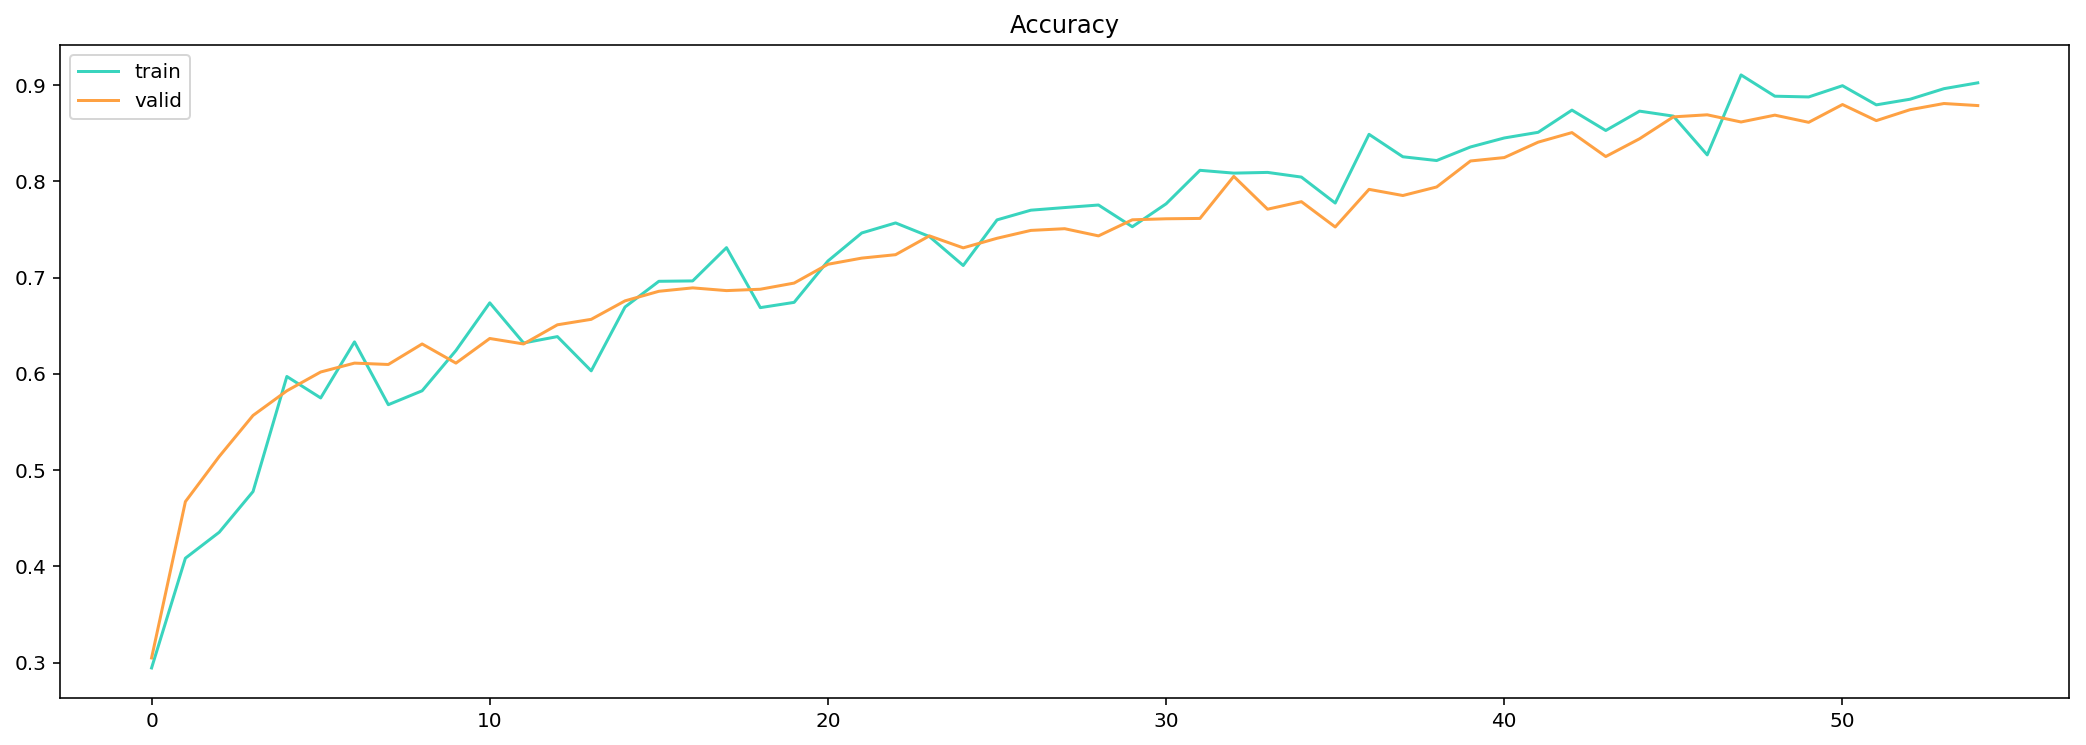

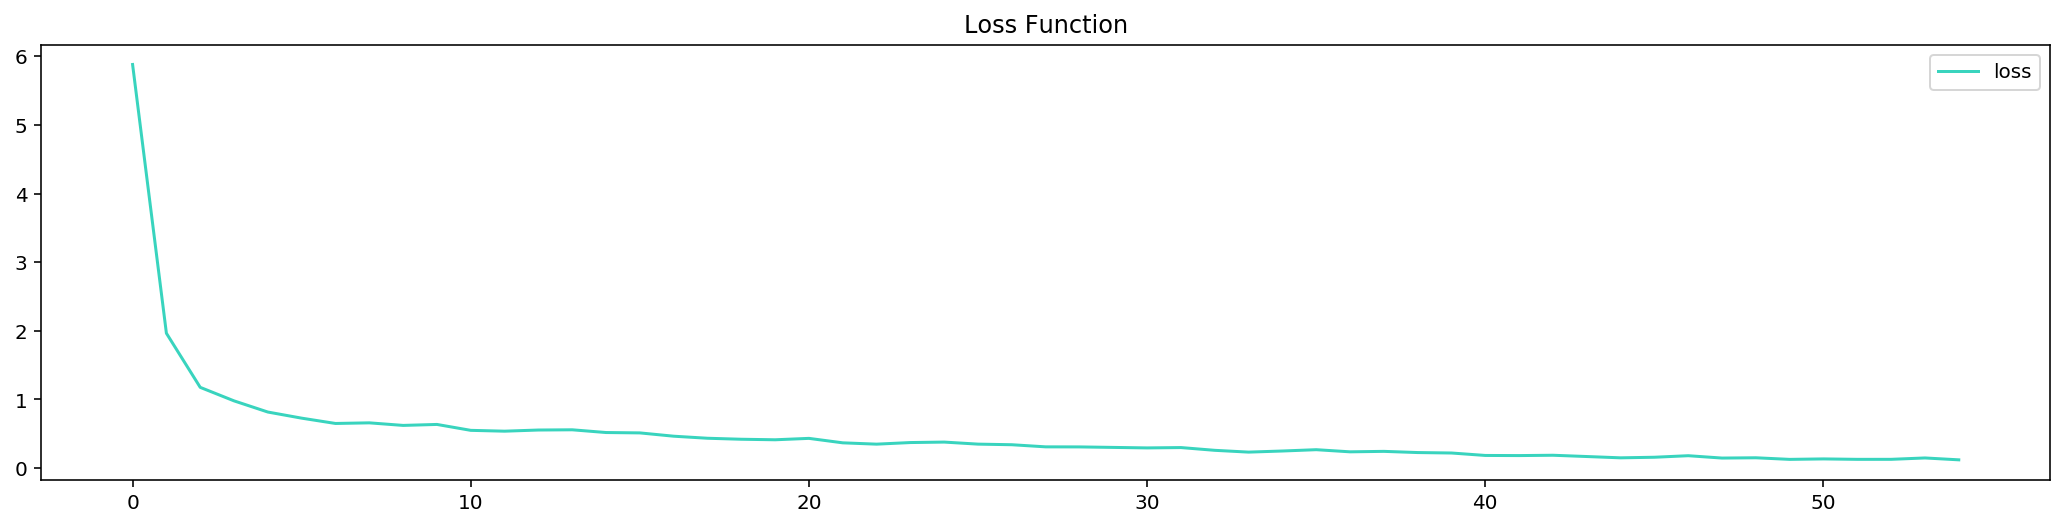

In [71]:
hide_code
summary_writer = tf.summary.FileWriter('output/tb_logs')
"""DON'T MODIFY ANYTHING IN THIS CELL"""

def get_accuracy(target, logits):
    """Calculate accuracy"""
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(target, [(0,0),(0,max_seq - target.shape[1])], 'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(logits, [(0,0),(0,max_seq - logits.shape[1]), (0,0)], 'constant')

    return np.mean(np.equal(target, np.argmax(logits, 2)))

train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]

valid_source = pad_sentence_batch(source_int_text[:batch_size])
valid_target = pad_sentence_batch(target_int_text[:batch_size])
TA, VA, L = [], [], []

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        start = time.time()
        for batch_i, (source_batch, target_batch) in \
        enumerate(batch_data(train_source, train_target, batch_size)):
            start_time = time.time()
            
            _, loss, summary_str = sess.run([train_op, cost, summary],
                                            {input_data: source_batch,
                                             targets: target_batch,
                                             lr: learning_rate,
                                             sequence_length: target_batch.shape[1],
                                             keep_prob: keep_probability})
            
            if batch_i % 100 == 0:
                summary_writer.add_summary(summary_str, batch_i)
            
            batch_train_logits = sess.run(
                inference_logits,
                {input_data: source_batch, keep_prob: 1.0})
            batch_valid_logits = sess.run(
                inference_logits,
                {input_data: valid_source, keep_prob: 1.0})
                
            train_acc = get_accuracy(target_batch, batch_train_logits)
            valid_acc = get_accuracy(np.array(valid_target), batch_valid_logits)
            end_time = time.time()
            if batch_i % 100 == 0:
                print('Epoch {:>3} | Batch {:>4}/{} | \
                Train Accuracy: {:>6.3f} | Validation Accuracy: {:>6.3f} | Loss: {:>6.3f}'\
                      .format(epoch_i, batch_i, len(source_int_text) // batch_size, 
                              train_acc, valid_acc, loss))
                TA.append(train_acc)
                VA.append(valid_acc)
                L.append(loss)
        print('Epoch Time: ', time.time() - start)

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    summary_writer.add_graph(sess.graph)
    summary_writer.flush()
    print('Model Trained and Saved')
    
    pyplot.figure(figsize=(18, 6))
    pyplot.plot(TA, color = '#39d4be', label = 'train')
    pyplot.plot(VA, color = '#fea143', label = 'valid')
    pyplot.legend()
    pyplot.title('Accuracy')
    
    pyplot.figure(figsize=(18, 4))
    pyplot.plot(L, color = '#39d4be', label = 'loss')
    pyplot.legend()
    pyplot.title('Loss Function');

### Save Parameters
Save the `batch_size` and `save_path` parameters for inference.

In [72]:
hide_code
"""DON'T MODIFY ANYTHING IN THIS CELL"""
# Save parameters for checkpoint
save_params(save_path)

# Checkpoint

In [73]:
hide_code
"""DON'T MODIFY ANYTHING IN THIS CELL"""

_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = load_preprocess()
load_path = load_params()

## Sentence to Sequence
To feed a sentence into the model for translation, you first need to preprocess it.  Implement the function `sentence_to_seq()` to preprocess new sentences.

- Convert the sentence to lowercase
- Convert words into ids using `vocab_to_int`
 - Convert words not in the vocabulary, to the `<UNK>` word id.

In [74]:
hide_code
def sentence_to_seq(sentence, vocab_to_int):
    """
    Convert a sentence to a sequence of ids
    :param sentence: String
    :param vocab_to_int: Dictionary to go from the words to an id
    :return: List of word ids
    """
    seq = [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in sentence.lower().split()]
    return seq


"""DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE"""
test_sentence_to_seq(sentence_to_seq)

Tests Passed


## Translate
This will translate `translate_sentence` from English to French.

In [75]:
hide_code
translate_sentence = 'he saw a old yellow truck .'

"""DON'T MODIFY ANYTHING IN THIS CELL"""
translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('logits:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence], keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence]))
print('  English Words: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in np.argmax(translate_logits, 1)]))
print('  French Words: {}'.format([target_int_to_vocab[i] for i in np.argmax(translate_logits, 1)]))

Input
  Word Ids:      [135, 211, 202, 175, 65, 66, 79]
  English Words: ['he', 'saw', 'a', 'old', 'yellow', 'truck', '.']

Prediction
  Word Ids:      [296, 80, 56, 83, 134, 230, 257, 130, 1]
  French Words: ['il', 'a', 'vu', 'un', 'vieux', 'camion', 'blanc', '.', '<EOS>']


## Imperfect Translation
You might notice that some sentences translate better than others.  Since the dataset you're using only has a vocabulary of 227 English words of the thousands that you use, you're only going to see good results using these words.  For this project, you don't need a perfect translation. However, if you want to create a better translation model, you'll need better data.

You can train on the [WMT10 French-English corpus](http://www.statmt.org/wmt10/training-giga-fren.tar).  This dataset has more vocabulary and richer in topics discussed.  However, this will take you days to train, so make sure you've a GPU and the neural network is performing well on dataset we provided.  Just make sure you play with the WMT10 corpus after you've submitted this project.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_language_translation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.